# (4): Visibility Fitting

In [18]:
import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
import cmasher as cmr          # color maps
%matplotlib inline                

# disk target name
disk_name = 'SR4'

# set this to your project directory (or however you like)
working_dir = '/Users/sandrews/Desktop/DSHARP_CPDs/'

# if you don't already have the datafile, download it
if not os.path.exists(working_dir+disk_name+'_continuum_tbin60s_SPWavg.vis.npz'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum_tbin60s_SPWavg.vis.npz'
    print('Downloading VISIBILITY data...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum_tbin60s_SPWavg.vis.npz')
    print('...Download complete.')

# load the visibility data
dat = np.load(disk_name+'_continuum_tbin60s_SPWavg.vis.npz')
u, v, vis, wgt = dat['u'], dat['v'], dat['Vis'], dat['Wgt']

# load the CLEAN surface brightness profile
r, SBr, err_SBr = np.loadtxt(disk_name+'_cleanSBr.txt').T

# fetch the beam properties (for convolution experiments)
data = fits.open(disk_name+'_continuum.fits')
header = data[0].header
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']

Let's take a look at the visibilities.  First, we'll define a general function that performs an analogous coordinate transformation as the one we used to make a radial surface brightness profile from the image in Part (2), including  deprojection, rotation, shift, and azimuthal averaging, but here in the Fourier domain:

In [19]:
# define a function to generate a 1-D visibility "profile"
def deproject_vis(data, bins=np.array([0]), incl=0., PA=0., offx=0., offy=0., errtype='mean'):
    
    # unpack the data
    u, v, vis, wgt = data
    
    # convert keywords into relevant units
    inclr = np.radians(incl)
    PAr = 0.5 * np.pi - np.radians(PA)
    offx *= -np.pi / (180 * 3600)
    offy *= -np.pi / (180 * 3600)

    # change to a deprojected, rotated coordinate system
    uprime = (u * np.cos(PAr) + v * np.sin(PAr))
    vprime = (-u * np.sin(PAr) + v * np.cos(PAr)) * np.cos(inclr)
    rhop = np.sqrt(uprime**2 + vprime**2)

    # phase shifts to account for offsets
    shifts = np.exp(-2 * np.pi * 1.0j * (u*-offx + v*-offy))
    visp = vis * shifts
    realp = visp.real
    imagp = visp.imag

    # if requested, return a binned (averaged) representation
    if (bins.size > 1):
        avbins = 1e3 * bins       # scale to lambda units (input in klambda)
        bwid = 0.5 * (avbins[1] - avbins[0])
        bvis = np.zeros_like(avbins, dtype='complex')
        berr = np.zeros_like(avbins, dtype='complex')
        for ib in np.arange(len(avbins)):
            inb = np.where((rhop >= avbins[ib] - bwid) & (rhop < avbins[ib] + bwid))
            if (len(inb[0]) >= 5):
                bRe, eRemu = np.average(realp[inb], weights=wgt[inb], returned=True)
                eRese = np.std(realp[inb])
                bIm, eImmu = np.average(imagp[inb], weights=wgt[inb], returned=True)
                eImse = np.std(imagp[inb])
                bvis[ib] = bRe + 1j*bIm
                if (errtype == 'scat'):
                    berr[ib] = eRese + 1j*eImse
                else: berr[ib] = 1 / np.sqrt(eRemu) + 1j / np.sqrt(eImmu)
            else:
                bvis[ib] = 0 + 1j*0
                berr[ib] = 0 + 1j*0
        parser = np.where(berr.real != 0)
        output = avbins[parser], bvis[parser], berr[parser]
        return output
    
    # if not, returned the unbinned representation
    output = rhop, realp + 1j*imagp, 1 / np.sqrt(wgt)

    return output

Then, we can look at the variation of the real and imaginary components of the visibilities (azimuthally-averaged in the disk plane) as a function of the (deprojected) baseline length of the interferometer:

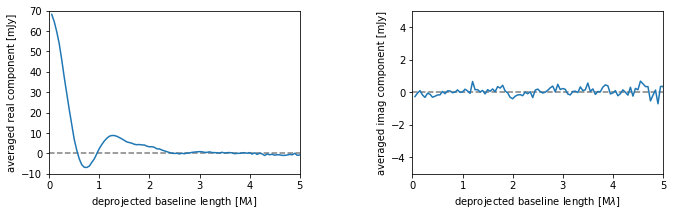

In [119]:
# the geometric inputs (this must be the same as used to make the profile!)
incl, PA = 24.2, 43.7
offRA, offDEC = -0.0636, -0.5090

# decide on the bins in (u,v)-distance for the profile, in kilo-lambda units
uvbins = np.arange(50, 13020, 50)

# generate the deprojected visibility profile
rho_dat, Vrho_dat, err_Vrho = deproject_vis([u, v, vis, wgt], bins=uvbins, incl=incl, PA=PA, offx=offRA, offy=offDEC)

# plot it!
fig, axs = plt.subplots(ncols=2, figsize=(11,3))
ax = axs[0]
ax.plot([0, 10], [0, 0], '--k', alpha=0.5)
ax.plot(rho_dat * 1e-6, Vrho_dat.real * 1e3)
ax.set_xlim([0, 5])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 70])
ax.set_ylabel('averaged real component [mJy]')

ax = axs[1]
ax.plot([0, 10], [0, 0], '--k', alpha=0.5)
ax.plot(rho_dat * 1e-6, Vrho_dat.imag * 1e3)
ax.set_xlim([0, 5])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-5, 5])
ax.set_ylabel('averaged imag component [mJy]')
fig.subplots_adjust(wspace=0.45)

Now, we want to develop a simple model to "fit" the data (the visibilities).  The model itself is a radial surface brightness profile, like the ones you've experimented with in the previous two parts.  But here, we calculate it on a specific discrete set of radial bins (i.e., an approximation such that the surface brightness is ~constant in each narrow radial bin).  First, we define these bins in a special format.  Recall from Part (2) that the emission extends to only ~0.3".  We'll make our model out to 50% further to be safe.  The intrinsic resolution of the data corresponds to the beam size, in this case ~0.03".  We want to over-sample that beam size by ~10x, so we're looking for ~3 milli-arcsecond radial bins:

In [21]:
# pre-define the radius bins you'll compute SB profile models on
b = np.arange(0.003, 0.453, 0.003)     # bin outer edges
a = np.roll(b, 1)                      # bin inner edges
rin = 0.1/140.                         # innermost bin's inner edge
a[0] = rin
rbin_centers = 0.5*(a+b)               # bin centers
rbin_edges = rin, b

Now we create a function that defines the surface brightness profile at those (or arbitrary) radial bins (and we can of course play with and modify this below):

In [118]:
def SB_model(pars, rbins):
        
    # parse the parameter values
    peakcore = pars[0]   # core component peak brightness (at center) in Jy / arcsec**2
    sig_core = pars[1]   # standard deviation (width) of core in arcseconds
    peakring = pars[2]   # ring component peak brightness in Jy / arcsec**2
    rring = pars[3]      # mean position of ring in arcseconds
    sig_ring = pars[4]   # standard deviation (width) of ring in arcseconds
    
    # compute the core intensity profile
    Inu_core = peakcore * np.exp(-0.5 * (rbins / sig_core)**2)
    
    # compute the ring intensity profile
    Inu_ring = peakring * np.exp(-0.5 * ((rbins - rring) / sig_ring)**2)
    
    return (Inu_core + Inu_ring)

Now we need to define a function that takes the Fourier transform of that surface brightness profile, projected back onto the sky coordinate frame for a given viewing geometry ($i$, PA, offsets).  This is not easy to parse, but the underlying math is fairly straightforward and builds off what we learned in the previous part.  Basically, we take a linear combination of the Fourier transforms from each discrete radial bin: remember, the Fourier transform of a constant intensity ring (i.e., a "top-hat") is just a Bessel function.  The tricky part is the actual algorithm, which is compacted in such a way as to not be obvious...but this does not matter (it is not required to understand this algorithm in full detail, but if you want you can read about it in this notebook for the math and this notebook for the code).

In [108]:
import scipy.special as sfunc

def vis_model(SB, rbins, pars, incl=0, PA=0, offRA=0, offDEC=0):

    # parse the geometric parameters (into radian units)
    inclr = np.radians(incl)
    PAr = 0.5 * np.pi - np.radians(PA)
    dx = offRA * np.pi / (180 * 3600)
    dy = offDEC * np.pi / (180 * 3600)
    
    # coordinate change to deal with projection and rotation
    uprime = u * np.cos(PAr) + v * np.sin(PAr)
    vprime = (-u * np.sin(PAr) + v * np.cos(PAr)) * np.cos(inclr)
    
    # deprojected baseline lengths
    rho = np.sqrt(uprime**2 + vprime**2) * np.pi / (180 * 3600)

    # re-orient the array of outer edges for the radius bins
    rin, b = rbins
    rbin = np.concatenate([np.array([rin]), b])

    # compute the matrix of jinc functions (Nvis x Nbins)
    jarg = np.outer(2 * np.pi * rbin, rho)
    jinc_matrix = sfunc.j1(jarg) / jarg

    # re-orient array of (binned) surface brightnesses
    Ibin = np.append(np.concatenate([np.array([0.0]), SB]), 0.)
    II = Ibin - np.roll(Ibin, -1)
    intensity = np.delete(II, SB.size)
    
    # compute the visibilities (a summation of Hankel transforms for each intensity annulus)
    vis = np.dot(2 * np.pi * rbin**2 * intensity, jinc_matrix)

    # impart a phase center shift
    shift = np.exp(-2 * np.pi * 1.0j * ((u * -dx) + (v * -dy)))    
    mvis = vis * shift

    return mvis

Now, let's generate an example model and compare it to the visibilities and a (simplified) convolved representation of the surface brightness profile.

In [115]:
# surface brightness model
pars = [2.4, 0.025, 0.55, 0.16, 0.05]
model_Inu = SB_model(pars, rbin_centers)

# 1-D convolution kernel
from astropy.convolution import Gaussian1DKernel, convolve
sig_beam = np.sqrt(beam_maj * beam_min) / (2 * np.sqrt(2 * np.log(2)))
psf = Gaussian1DKernel(stddev=sig_beam / np.mean(np.diff(rbin_centers[1:])))
Inu_model_conv = convolve(model_Inu, psf, boundary='extend')

# visibility model
model_FT = vis_model(model_Inu, rbin_edges, pars, incl=incl, PA=PA, offRA=offRA, offDEC=offDEC)
rho_model, Vrho_model, ign = deproject_vis([u, v, model_FT, wgt], bins=uvbins,
                                           incl=incl, PA=PA, offx=offRA, offy=offDEC)

And now make some plots to compare the data and model:

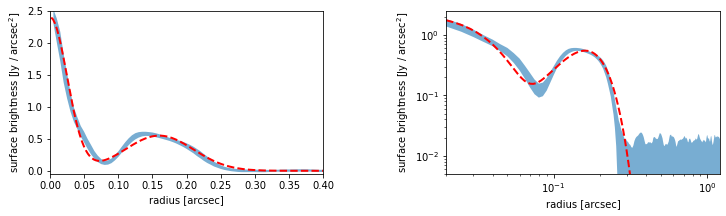

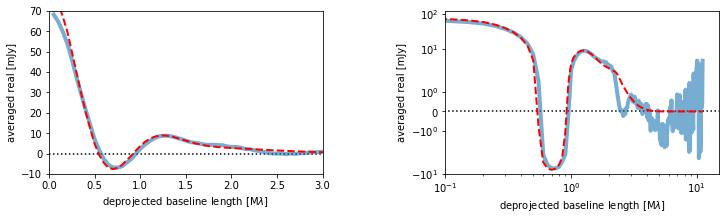

In [117]:
# surface brightness profiles
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

ax = axs[0]
ax.fill_between(rbins, SBr-err_SBr, SBr+err_SBr, alpha=0.6)
ax.set_xlim([0.0, 0.4])
ax.set_ylim([-0.05, 2.5])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')
ax.plot(rbin_centers, model_Inu, '--r', lw=2)

ax = axs[1]
ax.fill_between(rbins, SBr-err_SBr, SBr+err_SBr, alpha=0.6)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.02, 1.2])
ax.set_ylim([0.005, 2.5])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')
ax.plot(rbin_centers, model_Inu, '--r', lw=2)

fig.subplots_adjust(wspace=0.45)


# visibility profiles
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

ax = axs[0]
ax.plot([0, 15], [0, 0], ':k')
ax.plot(rho_dat * 1e-6, Vrho_dat.real * 1e3, alpha=0.6, lw=4)
ax.set_xlim([0, 3])
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 70])
ax.set_ylabel('averaged real [mJy]')
ax.plot(rho_model * 1e-6, Vrho_model.real * 1e3, '--r', lw=2)

ax = axs[1]
ax.plot([0, 15], [0, 0], ':k')
ax.plot(rho_dat * 1e-6, Vrho_dat.real * 1e3, alpha=0.6, lw=4)
ax.set_xlim([0.1, 15])
ax.set_xscale('log')
ax.set_xlabel('deprojected baseline length [M$\\lambda$]')
ax.set_ylim([-10, 125])
ax.set_yscale('symlog')
ax.set_ylabel('averaged real [mJy]')
ax.plot(rho_model * 1e-6, Vrho_model.real * 1e3, '--r', lw=2)

fig.subplots_adjust(wspace=0.45)

**Activities:**

So, once you have experimented with the code above, there is one especially useful thing to work on here:

- The example model defined above does a *pretty* good job explaining the data, but it fails notably in a few areas.  I do not think this is a simple fix where we can change the model parameters to improve the fit quality.  Instead, we probably need to make the model itself more sophisticated.  Think about what we might need to do to improve the match with the data.  I think one "easy" solution might be to add 2 more Gaussians, splitting both the "core" and the "ring" into 2 Gaussians each.  Another option might be to adopt different functional forms (not Gaussians)...but let's discuss that option after you try the 4-Gaussian model.  See if you can tune up the parameters manually to get a better fit to the data.  Even if you can't get it perfectly, the point here is to come up with an appropriate parameterization that is *capable* of describing the data...we'll use a different machinery to find the best parameters.

In [ ]:
# your code here